<a href="https://www.kaggle.com/code/pablorocamora/vit-keras-for-cell-classification?scriptVersionId=114066134" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -U -q tensorflow-addons
!pip install -q neptune-client neptune-tensorflow-keras tensorflow

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import os 
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import neptune.new as neptune
import cv2
from sklearn.model_selection import StratifiedKFold

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.6.4 which is incompatible.
rich 12.6.0 req

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


# Prepare the data


In [2]:
from sklearn.model_selection import train_test_split

num_classes = 2
input_shape = (32, 32, 3)

def getData(size = (32,32), norm=False, split=True, test_sz = .2, rand_st=9):
    path = '/kaggle/input/p3-apic-classification/cell_images/cell_images'
    d = {'Parasitized':1, 'Uninfected':0}
    x, y = list(), list()
    for idx, category in enumerate(['Uninfected','Parasitized']):
        print(category)
        for img in tqdm(os.listdir(join(path, category))):
            if img.endswith('.png'):
                img = join(path, category, img)
                im = cv2.imread(img, cv2.IMREAD_UNCHANGED)#
                im = cv2.resize(im, size)
                if norm:#Normalization 
                    im = im / 255.0
                    im = im.astype('float32')
                    
                x.append(im)
                y.append(idx)
    x = np.array(x) 
    y = np.array(y)
    
    if split:
        X_train, X_test, y_train, y_test = train_test_split(x, 
                                                            y, 
                                                            test_size=test_sz, 
                                                            stratify=y, 
                                                            random_state=rand_st)
        return X_train, X_test, y_train, y_test
    else:
        return x, y

    
X, y = getData(size = (32, 32), 
               norm=False, 
               split=False, 
               test_sz = .2, 
               rand_st=9)

Uninfected


100%|██████████| 12402/12402 [01:18<00:00, 157.85it/s]


Parasitized


100%|██████████| 12402/12402 [01:25<00:00, 145.26it/s]


# Configure the hyperparameters

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


# Use data augmentation 

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X)


2022-12-17 12:45:11.935428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 12:45:12.031059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 12:45:12.031885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 12:45:12.033287: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Implement multilayer perceptron (MLP)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Implement patch creation as a layer

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


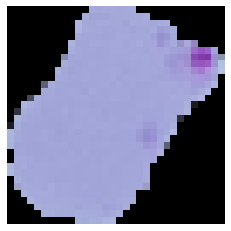

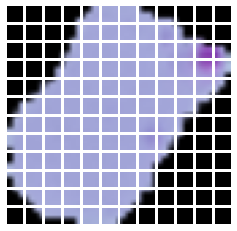

In [7]:
plt.figure(figsize=(4, 4))
image = X[np.random.choice(range(X.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


# Implement the patch encoder

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


# Build the ViT model

In [9]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1, activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


# Compile, train, and evaluate the mode

In [10]:
import sklearn.metrics

def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5)) # Accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1), model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy') 
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1, step=len(model_history.history['accuracy'])/10))
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1), model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss') 
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1, step=len(model_history.history['loss'])/10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()    
    
def getAllMetrics(y_pred, y_test):
    
    #Classification report
    target_names = ['Uninfected', 'Parasitized']
    report = sklearn.metrics.classification_report(y_test, y_pred, target_names=target_names, digits=4, zero_division='warn')
    print(report)
    
    #Confussion matrix
    print('Confussion matrix')
    cf_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_mat, annot=True,fmt="d")
    plt.show()

    
    #Roc Area cont
    plot_roc_curve(y_test, y_pred2)
    print(f'model 2 AUC score: {sklearn.metrics.roc_auc_score(y_test, y_pred2)}')

In [11]:
def run_experiment(model):
 
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=["accuracy"])
    model.summary()
    return model





Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_1[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 108)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 144, 64)      16192       patches_1[0][0]                  
______________________________________________________________________________________________

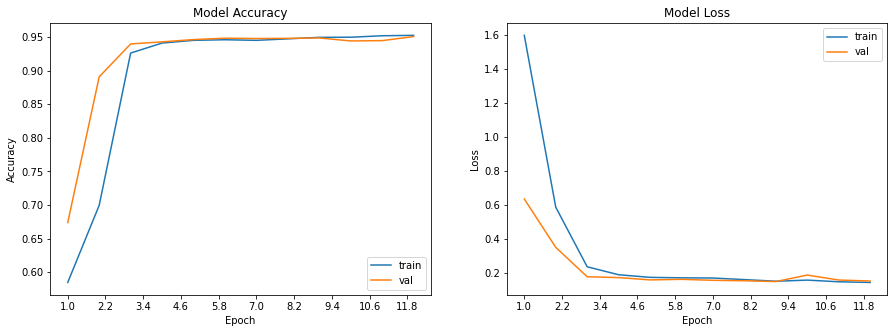

259/259 [==============================] - 6s 18ms/step
              precision    recall  f1-score   support

  Uninfected     0.9575    0.9436    0.9505      4134
 Parasitized     0.9444    0.9582    0.9512      4134

    accuracy                         0.9509      8268
   macro avg     0.9510    0.9509    0.9509      8268
weighted avg     0.9510    0.9509    0.9509      8268

Confussion matrix


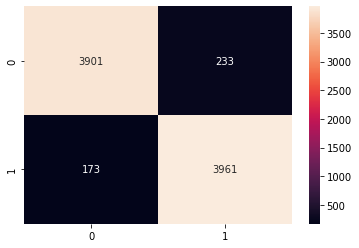

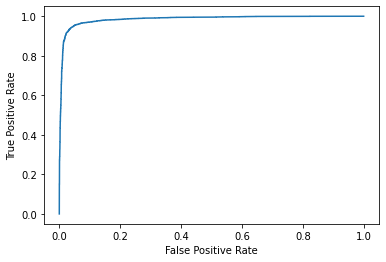

model 2 AUC score: 0.9850863864131656
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_2[0][0]                    
__________________________________________________________________________________________________
patches_2 (Patches)             (None, None, 108)    0           data_augmentation[1][0]          
__________________________________________________________________________________________________
patch_encoder_1 (PatchEncoder)  (None, 144, 64)      16192       patches_2[0][0]                  
______________________________________________________

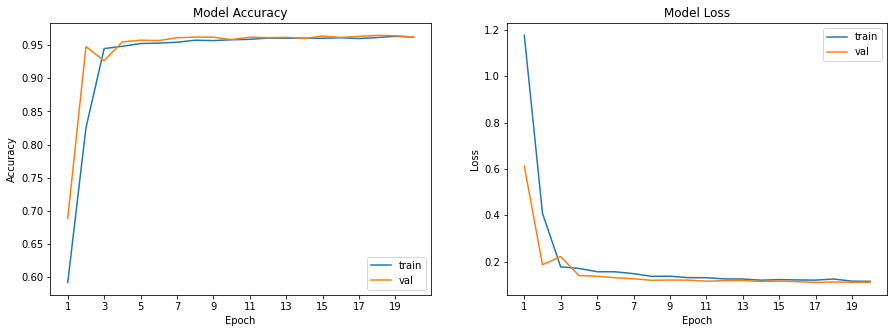

259/259 [==============================] - 6s 18ms/step
              precision    recall  f1-score   support

  Uninfected     0.9605    0.9642    0.9623      4134
 Parasitized     0.9641    0.9603    0.9622      4133

    accuracy                         0.9623      8267
   macro avg     0.9623    0.9623    0.9623      8267
weighted avg     0.9623    0.9623    0.9623      8267

Confussion matrix


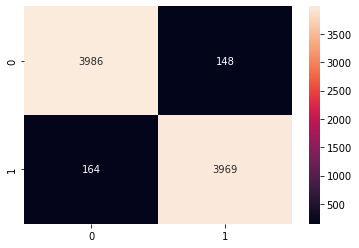

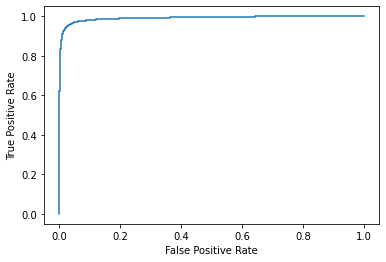

model 2 AUC score: 0.9908725491814206
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_3[0][0]                    
__________________________________________________________________________________________________
patches_3 (Patches)             (None, None, 108)    0           data_augmentation[2][0]          
__________________________________________________________________________________________________
patch_encoder_2 (PatchEncoder)  (None, 144, 64)      16192       patches_3[0][0]                  
______________________________________________________

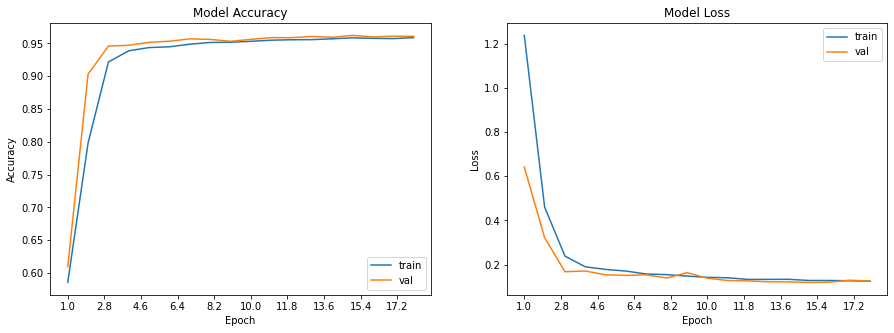

259/259 [==============================] - 6s 18ms/step
              precision    recall  f1-score   support

  Uninfected     0.9622    0.9596    0.9609      4133
 Parasitized     0.9597    0.9623    0.9610      4134

    accuracy                         0.9609      8267
   macro avg     0.9609    0.9609    0.9609      8267
weighted avg     0.9609    0.9609    0.9609      8267

Confussion matrix


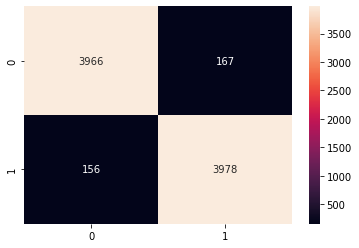

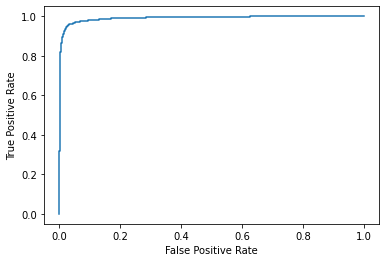

model 2 AUC score: 0.9909322478017154


In [12]:
kf = StratifiedKFold(n_splits=3)
for train, test in kf.split(X, y):
    vit_classifier = create_vit_classifier()
    model = run_experiment(vit_classifier)
    
    #TRAINING
    history = model.fit(X[train],
                        y[train],
                        batch_size = batch_size,
                        epochs = num_epochs,
                        validation_data = (X[test], y[test]),
                        callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)])

    #PLOT ACCURACY AND LOSS
    plot_model_history(history)
    
    #EVALUATION
    y_pred = model.predict(X[test], verbose=1)
    y_pred2 = y_pred
    y_pred = np.round(y_pred, 0)
    
        
    getAllMetrics(y_pred, y[test])

